<a href="https://colab.research.google.com/github/alliwene/toyota-model-classifier/blob/main/toyota_model_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # <center> <b>  TOYOTA BRANDS CLASSIFICATION </b> </center> 

In [12]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
import os, random, sys 
ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT, force_remount=True)  

Mounted at /content/drive


In [13]:
# set file path
path = "/content/drive/My Drive/toyota_data"
os.chdir(path)
!ls

'Copy of model_resnet101.pkl'   ngrok
 count_per_class.png	        ngrok-stable-linux-amd64.zip
 image_per_brand.png	        toyota-class.py
 model_resnet101.pkl	        toyota-model-classifier
 model_resnext50_32x4d.pkl      train
 models


In [3]:
# !pip install "torch==1.8.0" --quiet
!pip install -Uqq fastbook --quiet

     |████████████████████████████████| 727kB 17.5MB/s 
     |████████████████████████████████| 1.2MB 49.4MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 194kB 59.7MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 241kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [4]:
import fastbook
fastbook.setup_book() 

Mounted at /content/gdrive


In [5]:
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

### DataLoader

In [10]:
path = Path('train')

In [11]:
fns = get_image_files(path)
fns 

(#2283) [Path('train/Sienna/00000007.jpg'),Path('train/Sienna/00000005.jpg'),Path('train/Sienna/00000004.jpg'),Path('train/Sienna/00000000.jpg'),Path('train/Sienna/00000002.jpg'),Path('train/Sienna/00000001.jpg'),Path('train/Sienna/00000003.jpg'),Path('train/Sienna/00000006.jpg'),Path('train/Sienna/00000008.jpg'),Path('train/Sienna/00000012.jpg')...]

In [12]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [13]:
data = data_block.dataloaders(path,
                              batch_size=64)

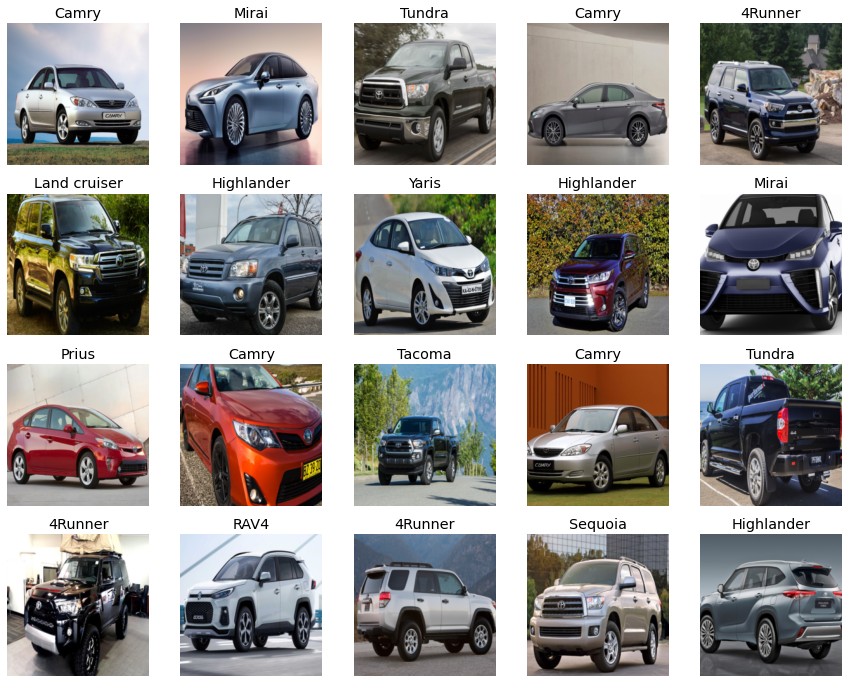

In [68]:
data.valid.show_batch(max_n=20, nrows=4) 

### ResNet50

In [20]:
# Create ResNet50
learner = cnn_learner(data, arch=resnet50,
                      metrics=[error_rate,accuracy],
                      path=path,
                      model_dir='models')
# Add callbacks
callbacks = [EarlyStoppingCallback(min_delta=1e-5, patience=3),
             SaveModelCallback()]

learner.callbacks = callbacks

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


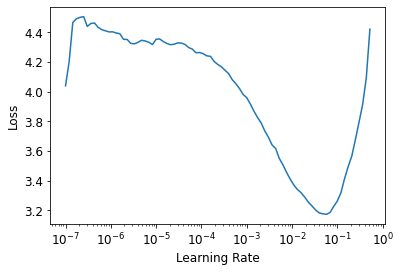

In [23]:
# check for optimal learning rate
lr_min,lr_steep = learner.lr_find(suggestions=True)

In [24]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-03, steepest point: 4.37e-03


In [25]:
# set learning rate and fit model 
learner.fine_tune(6, base_lr=3e-3, freeze_epochs=3) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.452147,2.815090,0.769737,0.230263,02:38
1,2.449240,3.212017,0.728070,0.271930,01:17
2,1.946961,3.552140,0.747807,0.252193,01:17


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.159860,3.037711,0.728070,0.271930,01:20
1,0.918745,2.703068,0.629386,0.370614,01:20
2,0.759442,2.286211,0.565789,0.434211,01:19
3,0.584145,2.684473,0.607456,0.392544,01:19
4,0.431231,2.224295,0.554825,0.445175,01:19
5,0.322740,2.196023,0.543860,0.456140,01:20


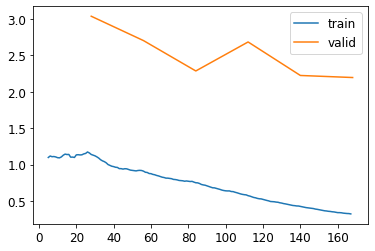

In [26]:
learner.recorder.plot_loss()

### ResNet101

Speed up training using mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training.

In [14]:
from fastai.callback.fp16 import *

In [24]:
# Create ResNet101
learner = cnn_learner(data, arch=resnet101,
                      metrics=[error_rate,accuracy],
                      path=path,
                      model_dir='models').to_fp16()
# Add callbacks
callbacks = [EarlyStoppingCallback(min_delta=1e-5, patience=3),
             SaveModelCallback()]

learner.callbacks = callbacks

In [25]:
learner.fine_tune(10, freeze_epochs=3) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.400639,2.433761,0.723684,0.276316,01:18
1,2.512980,2.734702,0.675439,0.324561,01:17
2,2.001760,3.020880,0.728070,0.271930,01:18


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.212647,2.127705,0.614035,0.385965,01:18
1,0.941167,1.849576,0.539474,0.460526,01:18
2,0.799527,2.292788,0.550439,0.449561,01:18
3,0.657394,2.740080,0.618421,0.381579,01:18
4,0.496107,1.899881,0.497807,0.502193,01:18
5,0.365945,2.054558,0.506579,0.493421,01:19
6,0.273653,1.496386,0.394737,0.605263,01:19
7,0.194750,1.652281,0.425439,0.574561,01:18
8,0.144562,1.510710,0.394737,0.605263,01:18
9,0.119468,1.550027,0.405702,0.594298,01:19


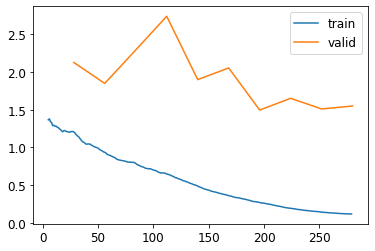

In [26]:
learner.recorder.plot_loss()

In [27]:
iterp = ClassificationInterpretation.from_learner(learner)

In [28]:
# check most confused predictions
iterp.most_confused(min_val=5)

[('Corolla', 'Camry', 16),
 ('Prius', 'Camry', 13),
 ('Avalon', 'Camry', 12),
 ('Supra', '86', 10),
 ('Mirai', 'Camry', 8),
 ('Sienna', 'Camry', 8),
 ('Venza', 'Camry', 8),
 ('Supra', 'Camry', 7),
 ('Yaris', 'Camry', 7),
 ('86', 'Camry', 6),
 ('RAV4', 'Camry', 6),
 ('Tundra', 'Tacoma', 6),
 ('Yaris', 'Prius', 6)]

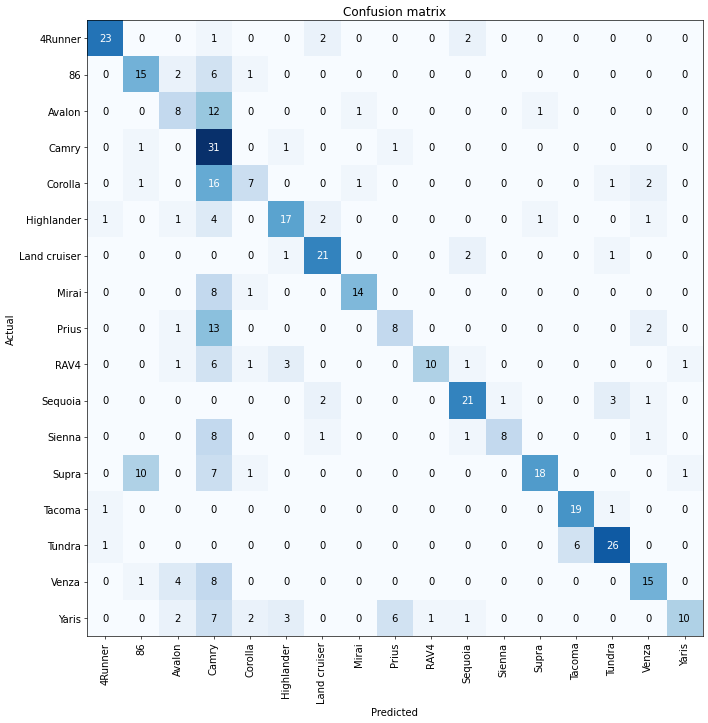

In [29]:
iterp.plot_confusion_matrix(figsize=(12,12), dpi=60)

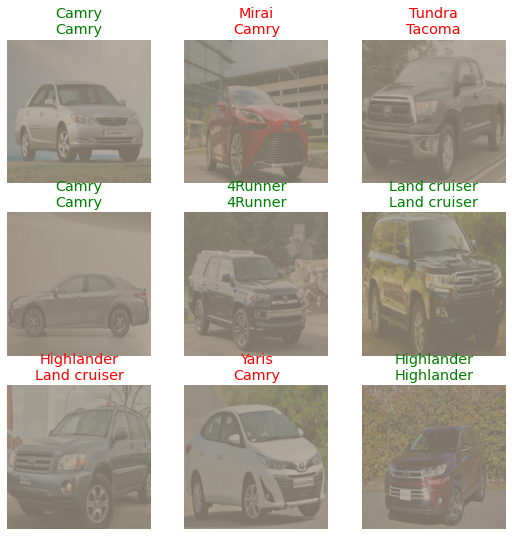

In [30]:
# compare predicted and ground truth images 
learner.show_results(dl=data.valid)

### Save model

In [32]:
learner.export('model_resnet101.pkl')

In [33]:
path.ls(file_exts='.pkl')

(#1) [Path('train/model_resnet101.pkl')]

In [36]:
load_learner('train/model_resnet101.pkl')

### Streamlit

In [7]:
!pip install streamlit --quiet

     |████████████████████████████████| 7.0MB 3.8MB/s 
     |████████████████████████████████| 112kB 54.7MB/s 
     |████████████████████████████████| 163kB 52.5MB/s 
     |████████████████████████████████| 4.6MB 49.0MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 122kB 38.2MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.0 which is incompatible.


Install ngrok

In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

pathconf: Transport endpoint is not connected
--2021-03-22 08:42:50--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.216.229.131, 54.197.133.26, 3.225.89.236, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.216.229.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
ngrok-stable-linux-amd64.zip: Transport endpoint is not connected

Cannot write to ‘ngrok-stable-linux-amd64.zip’ (Success).


In [14]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: ngrok                   


In [15]:
get_ipython().system_raw('./ngrok http 8501 &')

In [16]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://14db7ee2389f.ngrok.io


In [17]:
!streamlit run toyota-class.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.221.46.97:8501

2021-03-22 08:43:38.382 NumExpr defaulting to 2 threads.
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
  Stopping...
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
    self._writeout_input_cache(conn)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
    (self.session_number,)+line)
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139721455453952 and this is thread id 139721985836928.
